In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import classification_report

%matplotlib inline

## Load the dataset

In [2]:
mypath = '/Users/yinzi/Downloads/UTKFace'
filenames = np.array([f for f in listdir(mypath) if isfile(join(mypath, f))])
splitcolumns = [x.split('_')[0:3] + [mypath +'/' + x] for x in filenames if x.count('_') == 3]
filecolumns = ['age','gender','race','file']
df = pd.DataFrame(data = splitcolumns, columns = filecolumns)

In [3]:
df.head(3)

,age,gender,race,file
0,9,1,2,/Users/yinzi/Downloads/UTKFace/9_1_2_201612192...
1,36,0,1,/Users/yinzi/Downloads/UTKFace/36_0_1_20170117...
2,86,1,0,/Users/yinzi/Downloads/UTKFace/86_1_0_20170120...


In [6]:
df.shape

(23705, 4)

In [4]:
print(df['age'].unique())   # 99 ages on target variable age
print(len(df['age'].unique()))

['9' '36' '86' '26' '1' '52' '25' '16' '27' '58' '6' '35' '2' '53' '23'
 '24' '75' '50' '15' '37' '10' '22' '29' '21' '46' '17' '63' '34' '61'
 '18' '20' '32' '30' '45' '31' '43' '3' '54' '60' '49' '59' '41' '82' '40'
 '5' '44' '76' '8' '28' '56' '39' '4' '96' '12' '67' '47' '48' '19' '62'
 '38' '71' '89' '90' '14' '68' '33' '80' '42' '65' '57' '7' '69' '55' '85'
 '78' '81' '13' '51' '66' '79' '64' '83' '11' '87' '77' '73' '70' '74'
 '92' '72' '88' '99' '84' '100' '93' '105' '95' '116' '103' '110' '91'
 '101' '111' '115']
104


In [5]:
# convert all the object data type to numerical data
df['age']= df['age'].astype('int')
df['gender']= df['gender'].astype('int')
df['race']= df['race'].astype('int')
df.dtypes

age        int64
gender     int64
race       int64
file      object
dtype: object

1. infancy (0-2)
2. Early Childhood (Ages 3-5)
3. Middle Childhood (Ages 6-8)
4. Late Childhood (Ages 9-11)
5. Adolescence (Ages 12-20)
6. Early Adulthood (Ages 21-35)
7. Midlife (Ages 36-50)
8. Mature Adulthood (Ages 51-79)
9. Late Adulthood (Age 80+)

In [7]:
df['age'].min(), df['age'].max()

(1, 116)

In [8]:
# put the age in different interval
df['age']=np.where(((df.age>=1) & (df.age<=2)), 1, df.age)
df['age']=np.where(((df.age>=3) & (df.age<6)), 2, df.age)
df['age']=np.where(((df.age>=6) & (df.age<9)), 3, df.age)
df['age']=np.where(((df.age>=9) & (df.age<12)), 4, df.age)
df['age']=np.where(((df.age>=12) & (df.age<21)), 5, df.age)
df['age']=np.where(((df.age>=21) & (df.age<36)), 6, df.age)
df['age']=np.where(((df.age>=36) & (df.age<51)), 7, df.age)
df['age']=np.where(((df.age>=51) & (df.age<80)), 8, df.age)
df['age']=np.where((df.age>=80), 9, df.age)

In [9]:
age1 = sorted(df['age'].unique())
age1

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [78]:
df['age'].dtype

dtype('int64')

In [6]:
images = []
for img_path in df['file']:
    image = plt.imread(img_path)
    images.append(image)

In [7]:
from skimage import color
from skimage import io

## Image Preprocessing + Gray scale image + Data Frame

In [8]:
gray_images = []
for img in images:
    img_gray = color.rgb2gray(img)
    gray_images.append(img_gray)

In [9]:
# scaling the features so that each feature takes on a value between 0 and 1
images_gray = np.array(gray_images)/255

In [10]:
images_gray.shape

(9778, 200, 200)

In [11]:
df_gray_images = pd.DataFrame(np.array(gray_images).reshape(9778, 200*200))
df_gray_images.head(3)

,0,1,2,3,4,5,6,7,8,9,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
0,0.398611,0.386846,0.375081,0.359395,0.345390,0.341469,0.347057,0.347057,0.344817,0.360503,...,0.606749,0.614592,0.634200,0.645965,0.657729,0.661651,0.657164,0.653242,0.657164,0.657164
1,0.271999,0.264156,0.248470,0.240627,0.242867,0.266396,0.297203,0.324654,0.339775,0.363304,...,0.833958,0.837880,0.828065,0.824143,0.820222,0.808457,0.796692,0.784927,0.773163,0.765320
2,0.025426,0.037191,0.041113,0.037191,0.027376,0.039140,0.070513,0.101885,0.083111,0.083111,...,0.045965,0.045965,0.043182,0.043182,0.039260,0.035339,0.035339,0.031417,0.027496,0.027496


## 1. Age Classification
### 1.1 Gradient Boosting with original feature

In [30]:
X = df_gray_images
y = df['age']
print(list(y[0:5]))

[4, 1, 5, 1, 6]


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [32]:
X_train.shape, X_test.shape

((6844, 40000), (2934, 40000))

In [33]:
gbc=GradientBoostingClassifier(n_estimators=500,learning_rate=0.05,random_state=100,max_features=5, max_depth = 3)

In [34]:
gbc.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.05, max_features=5, n_estimators=500,
                           random_state=100)

In [35]:
y_pred = gbc.predict(X_test)

In [36]:
print(confusion_matrix(y_test, y_pred))

[[434  21   2   1   1  10   2  14   0]
 [ 78  60   8   6  14  18   1  17   0]
 [ 25  19  17   2  30  31   3  19   0]
 [ 10  12   7   9  31  19   3  21   0]
 [  7   9   7   6  95 155  11  39   0]
 [  9   3   1   0  42 426  57  79   1]
 [  1   2   0   0  10 122  90 133   0]
 [  2   2   1   1  21  73  58 390   8]
 [  0   1   0   0   3   8   3  98  15]]


In [37]:
GBC_accuracy_score = accuracy_score(y_test, y_pred)
print("GBC accuracy is %2.2f" % GBC_accuracy_score)

GBC accuracy is 0.52


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.77      0.89      0.83       485
           2       0.47      0.30      0.36       202
           3       0.40      0.12      0.18       146
           4       0.36      0.08      0.13       112
           5       0.38      0.29      0.33       329
           6       0.49      0.69      0.58       618
           7       0.39      0.25      0.31       358
           8       0.48      0.70      0.57       556
           9       0.62      0.12      0.20       128

    accuracy                           0.52      2934
   macro avg       0.49      0.38      0.39      2934
weighted avg       0.51      0.52      0.49      2934



* Convert RGB image to gray scale image and no other feature extraction, the Gradient Boosting accuracy_socre is 0.52

### 1.2 Gradient Boosting + PCA

In [39]:
from sklearn.decomposition import PCA

In [40]:
pca = PCA(n_components = 195)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [41]:
gbc.fit(X_train_pca,y_train)
y_pred_pca = gbc.predict(X_test_pca)

In [42]:
print(confusion_matrix(y_test, y_pred_pca))

[[417  23   2   0   5  18   2  18   0]
 [ 83  35   7   1  20  32   3  21   0]
 [ 17  23   9   2  27  37   7  24   0]
 [  9   8   4   5  32  25   5  24   0]
 [  6   9   2   4  88 145  20  54   1]
 [ 12   2   1   1  48 411  68  73   2]
 [  1   0   0   1   9 128  88 131   0]
 [  9   1   2   1  18  94  46 377   8]
 [  2   1   1   0   1   7   6  92  18]]


In [43]:
GBC_accuracy_pca_score = accuracy_score(y_test, y_pred_pca)
print("GBC accuracy is %2.2f" % GBC_accuracy_pca_score)

GBC accuracy is 0.49


In [44]:
print(classification_report(y_test, y_pred_pca))

              precision    recall  f1-score   support

           1       0.75      0.86      0.80       485
           2       0.34      0.17      0.23       202
           3       0.32      0.06      0.10       146
           4       0.33      0.04      0.08       112
           5       0.35      0.27      0.31       329
           6       0.46      0.67      0.54       618
           7       0.36      0.25      0.29       358
           8       0.46      0.68      0.55       556
           9       0.62      0.14      0.23       128

    accuracy                           0.49      2934
   macro avg       0.44      0.35      0.35      2934
weighted avg       0.47      0.49      0.45      2934



* The pca didn't improve the Gradient Boosting Classifier prediction accuracy. The prediction accuracy is decrease to 0.49

### 1.3 Gradient Boosting + Random Forest Feature importance feature selection

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [46]:
selector = SelectFromModel(RandomForestClassifier(n_estimators = 100))
selector.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [47]:
selected_feature= X_train.columns[(selector.get_support())]
len(selected_feature)

14366

In [48]:
X_train_selected = X_train.loc[:, selected_feature]
X_train_selected.shape

(6844, 14366)

In [49]:
X_test_selected = X_test.loc[:, selected_feature]
X_test_selected.shape

(2934, 14366)

In [50]:
gbc.fit(X_train_selected,y_train)
y_pred_selected = gbc.predict(X_test_selected)

In [51]:
print(confusion_matrix(y_test, y_pred_selected))

[[431  25   1   0   3   9   1  15   0]
 [ 81  59   5   5  20  20   0  12   0]
 [ 19  27  17   4  32  28   3  15   1]
 [  8  12   6   8  38  25   0  15   0]
 [  3   7   6   7 102 150  13  40   1]
 [  7   4   1   1  49 421  61  73   1]
 [  1   2   0   0   7 121 104 123   0]
 [  2   1   0   1  18  74  51 399  10]
 [  1   1   0   0   0   9   4  91  22]]


In [52]:
GBC_accuracy_selected_score = accuracy_score(y_test, y_pred_selected)
print("GBC accuracy is %2.2f" % GBC_accuracy_selected_score)

GBC accuracy is 0.53


In [53]:
print(classification_report(y_test, y_pred_selected))

              precision    recall  f1-score   support

           1       0.78      0.89      0.83       485
           2       0.43      0.29      0.35       202
           3       0.47      0.12      0.19       146
           4       0.31      0.07      0.12       112
           5       0.38      0.31      0.34       329
           6       0.49      0.68      0.57       618
           7       0.44      0.29      0.35       358
           8       0.51      0.72      0.60       556
           9       0.63      0.17      0.27       128

    accuracy                           0.53      2934
   macro avg       0.49      0.39      0.40      2934
weighted avg       0.52      0.53      0.50      2934



* Using Random forest importance for feature selection before the Gradient Boosting model. The prediction accuracy is about 0.53. It's still low.

### 1.4 Gradient Boosting + Random Forest feature selection + PCA

In [54]:
X_train_selected_pca = pca.fit_transform(X_train_selected)
X_test_selected_pca = pca.transform(X_test_selected)

In [55]:
X_train_selected_pca.shape, X_test_selected_pca.shape

((6844, 195), (2934, 195))

In [56]:
gbc.fit(X_train_selected_pca,y_train)
y_pred_selected_pca = gbc.predict(X_test_selected_pca)

In [57]:
print(confusion_matrix(y_test, y_pred_selected_pca))

[[421  28   1   0   2  13   2  16   2]
 [ 88  39   2   2  12  31   2  26   0]
 [ 26  16  10   4  28  44   3  15   0]
 [  7  12   4   3  28  28   5  24   1]
 [  7   7   1   6  76 159  11  62   0]
 [ 12   2   2   0  35 430  63  74   0]
 [  3   0   1   0  10 124  93 127   0]
 [  8   4   2   0  22  88  54 370   8]
 [  2   2   0   0   6   7   3  92  16]]


In [58]:
GBC_accuracy_selected_pca_score = accuracy_score(y_test, y_pred_selected_pca)
print("GBC accuracy is %2.2f" % GBC_accuracy_selected_pca_score)

GBC accuracy is 0.50


In [59]:
print(classification_report(y_test, y_pred_selected_pca))

              precision    recall  f1-score   support

           1       0.73      0.87      0.80       485
           2       0.35      0.19      0.25       202
           3       0.43      0.07      0.12       146
           4       0.20      0.03      0.05       112
           5       0.35      0.23      0.28       329
           6       0.47      0.70      0.56       618
           7       0.39      0.26      0.31       358
           8       0.46      0.67      0.54       556
           9       0.59      0.12      0.21       128

    accuracy                           0.50      2934
   macro avg       0.44      0.35      0.35      2934
weighted avg       0.47      0.50      0.46      2934



* Gradient Boosting model with Random forest feature selection and pca, the model predication accuracy decrease to 0.50.

In [60]:
# GB stands for Gradient Boosting
# PCA stands for principle component Analysis
# RFS stands for Random Forest Fature Selection
columns = ['GB', 'GB+PCA', 'GB+RFS', 'GB+RFS+PCA'] 

In [61]:
data = [GBC_accuracy_score, GBC_accuracy_pca_score, GBC_accuracy_selected_score, GBC_accuracy_selected_pca_score]

In [62]:
data = np.array([data])
print (data)

[[0.52351738 0.4935242  0.53271984 0.49693252]]


In [80]:
df = pd.DataFrame(data, columns=columns)
df

,GB,GB+PCA,GB+RFS,GB+RFS+PCA
0,0.523517,0.493524,0.53272,0.496933


In [64]:
data1 = {'GB':GBC_accuracy_score, 'GB+PCA':GBC_accuracy_pca_score, 'GB+RFS':GBC_accuracy_selected_score, 'GB+RFS+PCA':GBC_accuracy_selected_score  
}

In [65]:
values = list(data1.values())
names = list(data1.keys())

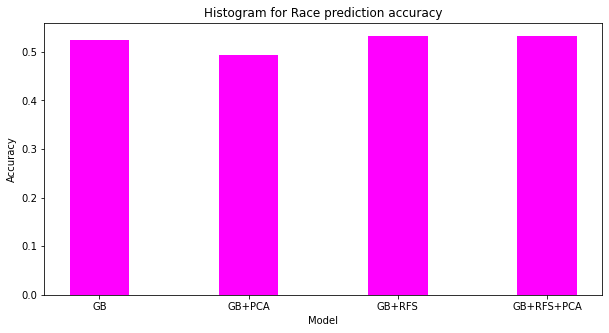

In [67]:
fig = plt.figure(figsize = (10, 5))
plt.bar(names, values, color = 'magenta', width=0.4)
plt.xlabel("Model")
plt.ylabel('Accuracy')
plt.title("Histogram for age prediction accuracy")
plt.show()

* As we can see this bar graph, those accuracy are similar and low.